In [1]:
# To start doing this problems, the first thing we need to do is to try to predict the IBEX with the general ARIMA without any other variable
# to check how good this model performs without taking into account extra variables

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('Session 12. Ibex.csv.', sep = ";",decimal = ",", encoding= 'unicode_escape')
y = data.iloc[:,1] # ibex
x1 = data.iloc[:,2] # exchange
x2 = data.iloc[:,3] # short term
x3 = data.iloc[:,4] # long term

# all variables are not stationary
print(data.head(5))

   Week  IBEX  Exchange rate /$  Short term rate  Long term rate
0     1  2664              0.590             12.7            11.5
1     2  2610              0.585             12.8            11.6
2     3  2571              0.580             12.8            11.6
3     4  2411              0.569             13.0            11.9
4     5  2293              0.584             13.6            12.6


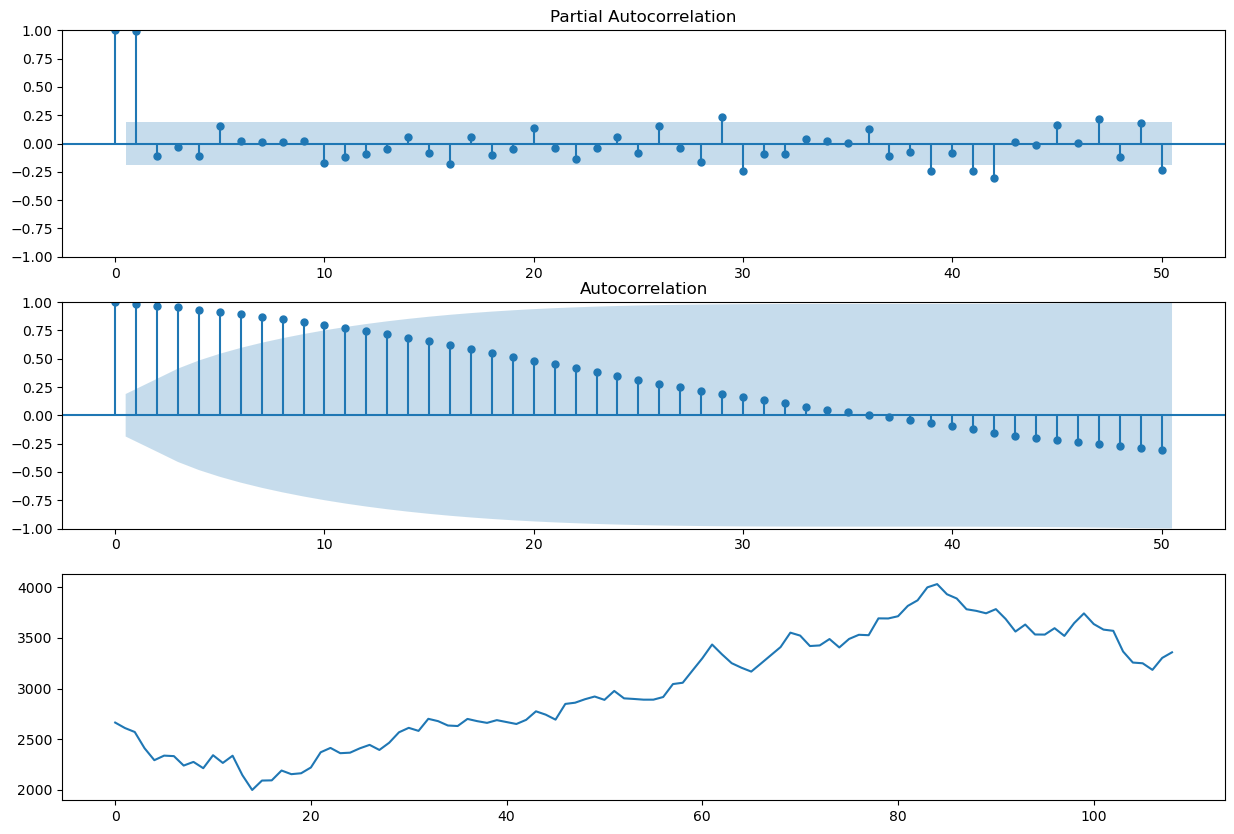

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
nlags = 50 # play with this parameter

fig, ax = plt.subplots(3,1, figsize = (15,10))
# if we plot y we are plotting the IBEX
# we can see that the IBEX time series is not stationary
plot_pacf(y, lags = nlags, method="ols", ax=ax[0])
plot_acf(y, lags = nlags, ax=ax[1])
ax[2] = plt.plot(y)
plt.show()

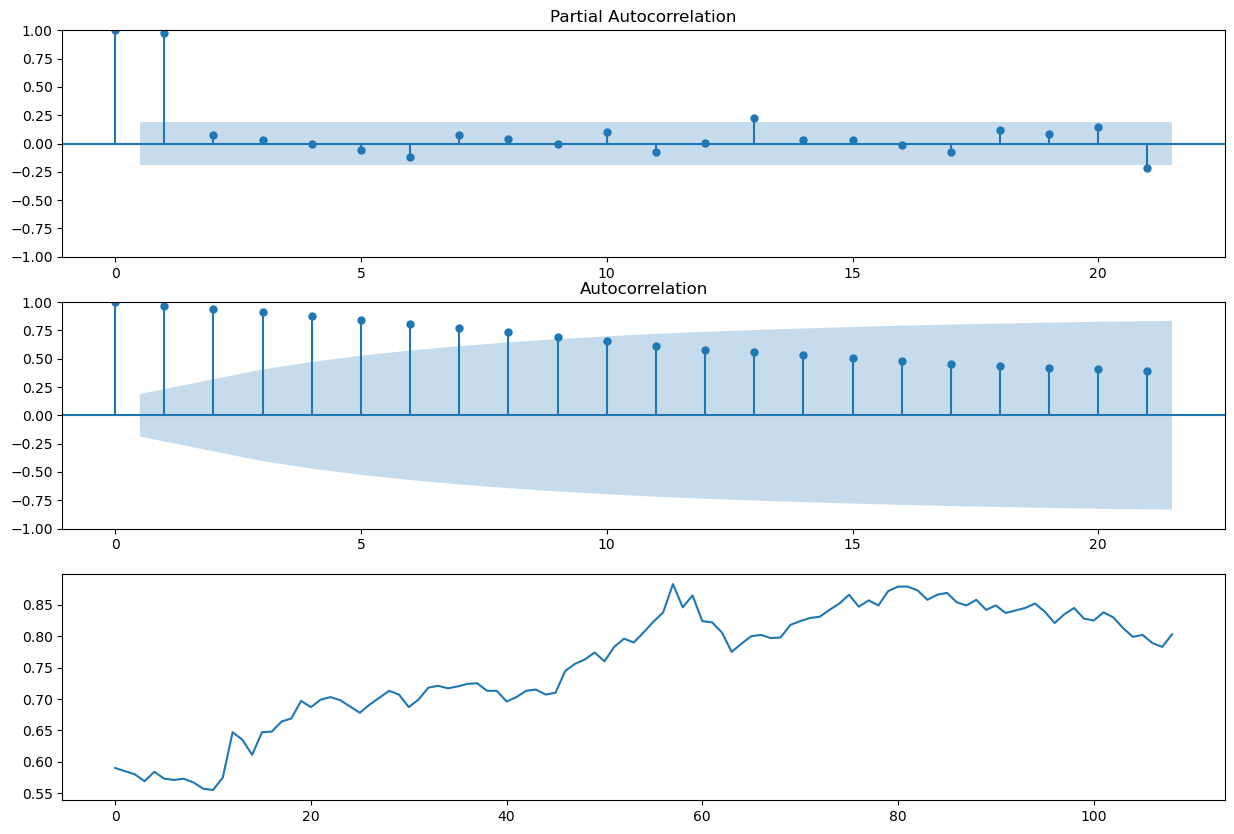

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
nlags = 50 # play with this parameter

fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(x1, method="ols", ax=ax[0])
plot_acf(x1, ax=ax[1])
ax[2] = plt.plot(x1)
plt.show()

#x1 is also not stationary

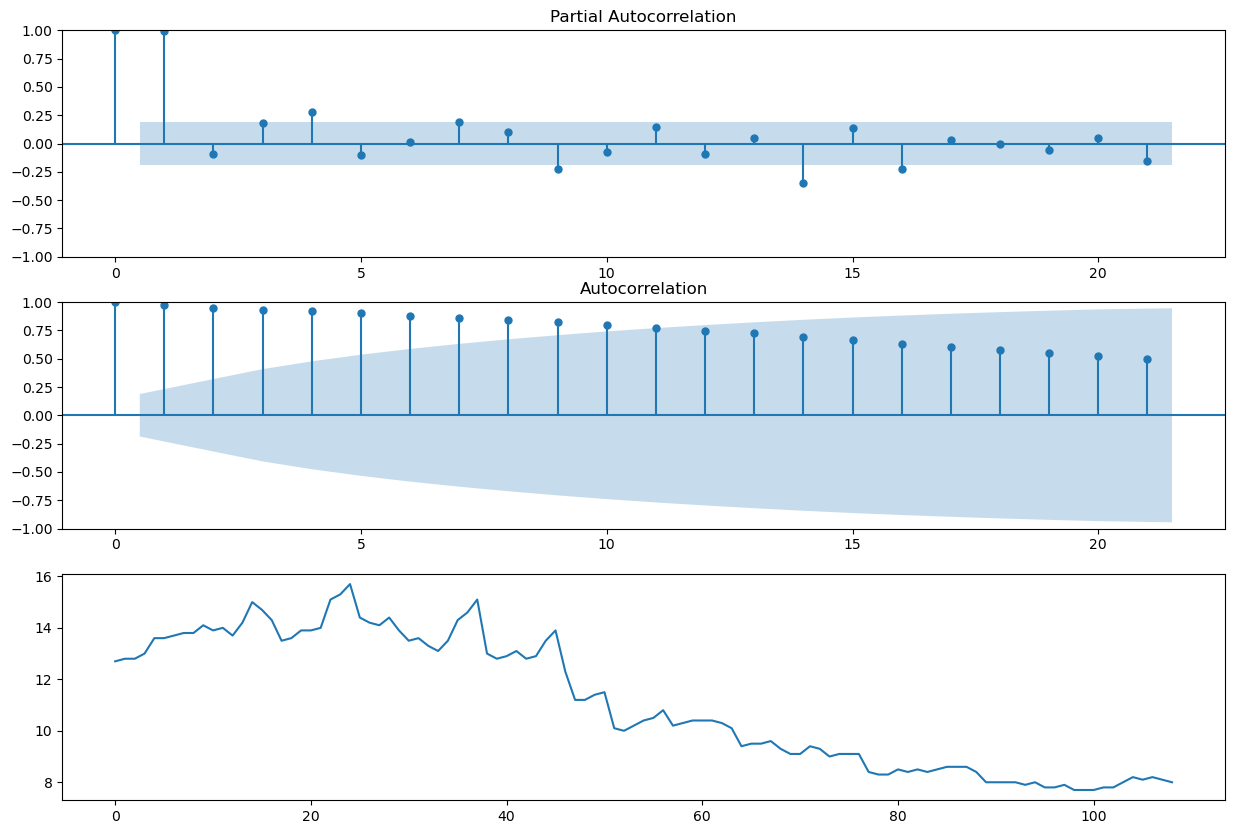

In [7]:
fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(x2, method="ols", ax=ax[0])
plot_acf(x2, ax=ax[1])
ax[2] = plt.plot(x2)
plt.show()

# x2 is not stationary

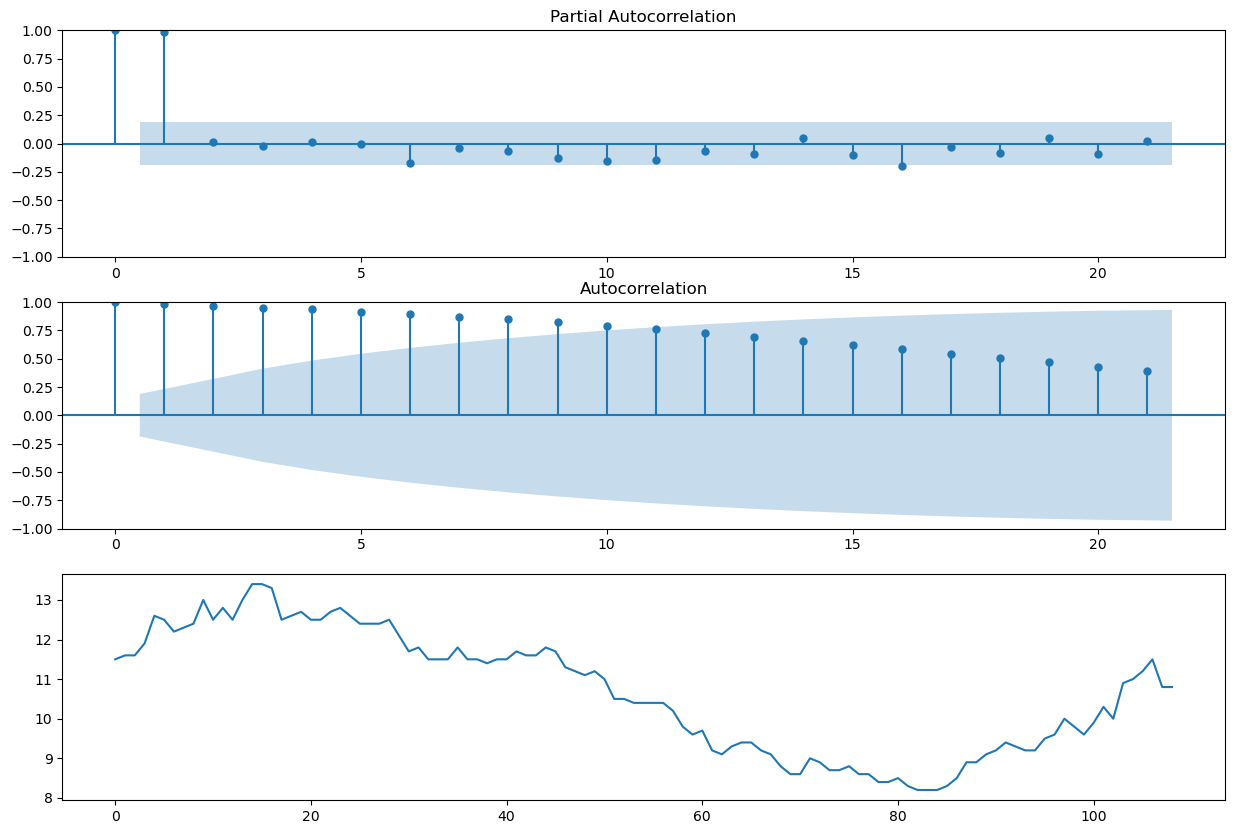

In [9]:
fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(x3, method="ols", ax=ax[0])
plot_acf(x3, ax=ax[1])
ax[2] = plt.plot(x3)
plt.show()

# x3 is not stationary

In [11]:
# lets start by looking at the model for IBEX

import statsmodels.api as sm
from pmdarima.arima import ndiffs, nsdiffs
print('Regular Difference:', ndiffs(y, alpha = 0.05, test = 'adf'))

box_test = sm.stats.acorr_ljungbox(y, lags=[20])
print("Box test")
print(box_test)

# with the box test we see that our original data (the IBEX) is correlated, we can also see from the ADF and pACF test

Regular Difference: 1
Box test
        lb_stat      lb_pvalue
20  1469.769053  1.216910e-299


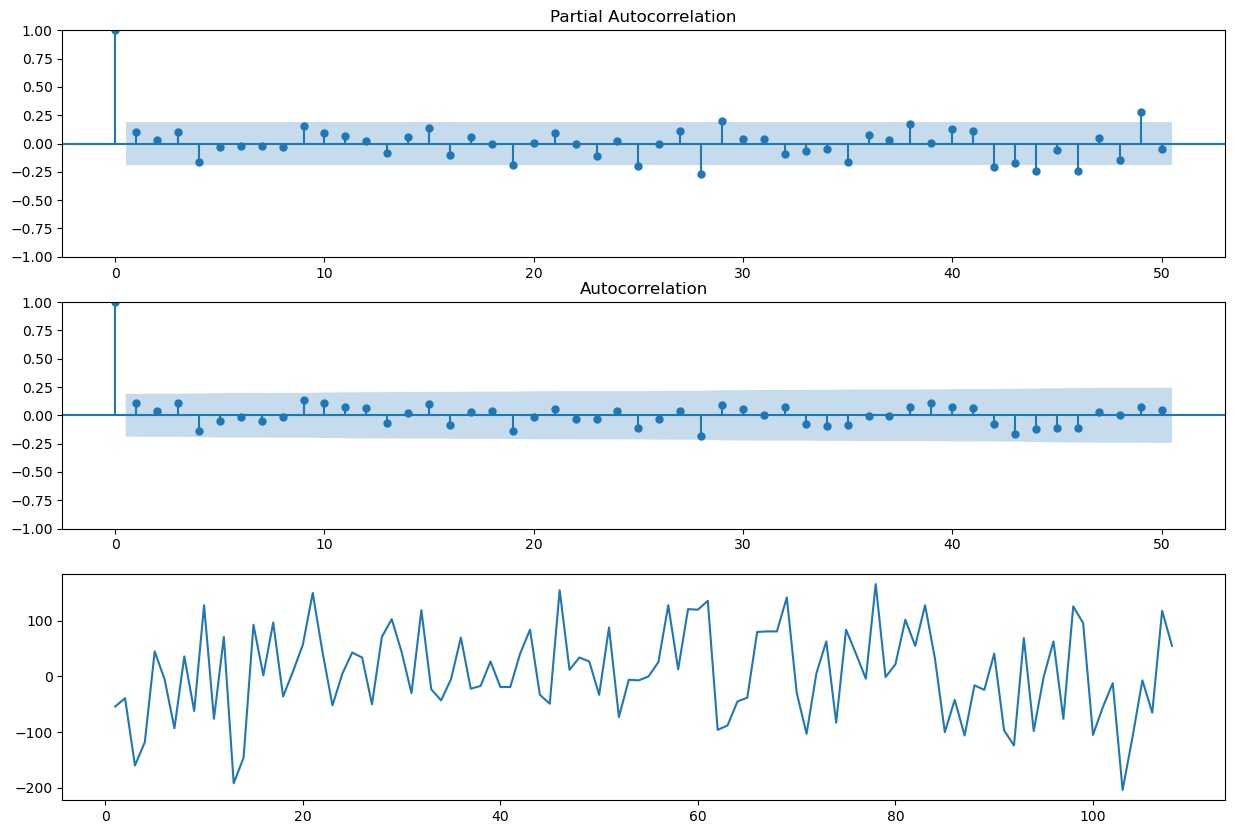

In [13]:
# first we take 1 diff for IBEX
r = y.diff().dropna()

fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(r, lags = nlags, method="ols", ax=ax[0])
plot_acf(r, lags = nlags, ax=ax[1])
ax[2] = plt.plot(r)
plt.show()

# the data is stationary, also looking at the ACF is already stationary because we dont have that slowly decay to 0
# from the ACF and pACF we cannot see clear if the data is WN or not, it looks like we dont have anything clear out of bounds in the short term

In [15]:
# when checking the formal test, we see that p value > 0.05, we dont reject H0, therefore data uncorrelated
# therefore our data is already WN, we cannot improve the linear model anymore
# so the best model for IBEX is an ARIMA (0,1,0)
# the model is IBEXt - IBEXt-1 = et
# IBEXt = IBEXt-1 + et --> this is our model, it is an autorregresive of order 1 (because it depends on the previous value ofIBEXt-1)
# with phi0=0 and phi1=1 
# so the best point prediction for IBEX in the coming week (as the model is measured in weeks) is the previous week
# we need to introduce the other independent random variables because if we dont innclude those variables, the prediction of the IBEX is quite bad

box_test = sm.stats.acorr_ljungbox(r, lags=[20])
print("Box test for r")
print(box_test)

Box test for r
      lb_stat  lb_pvalue
20  16.037784   0.714277


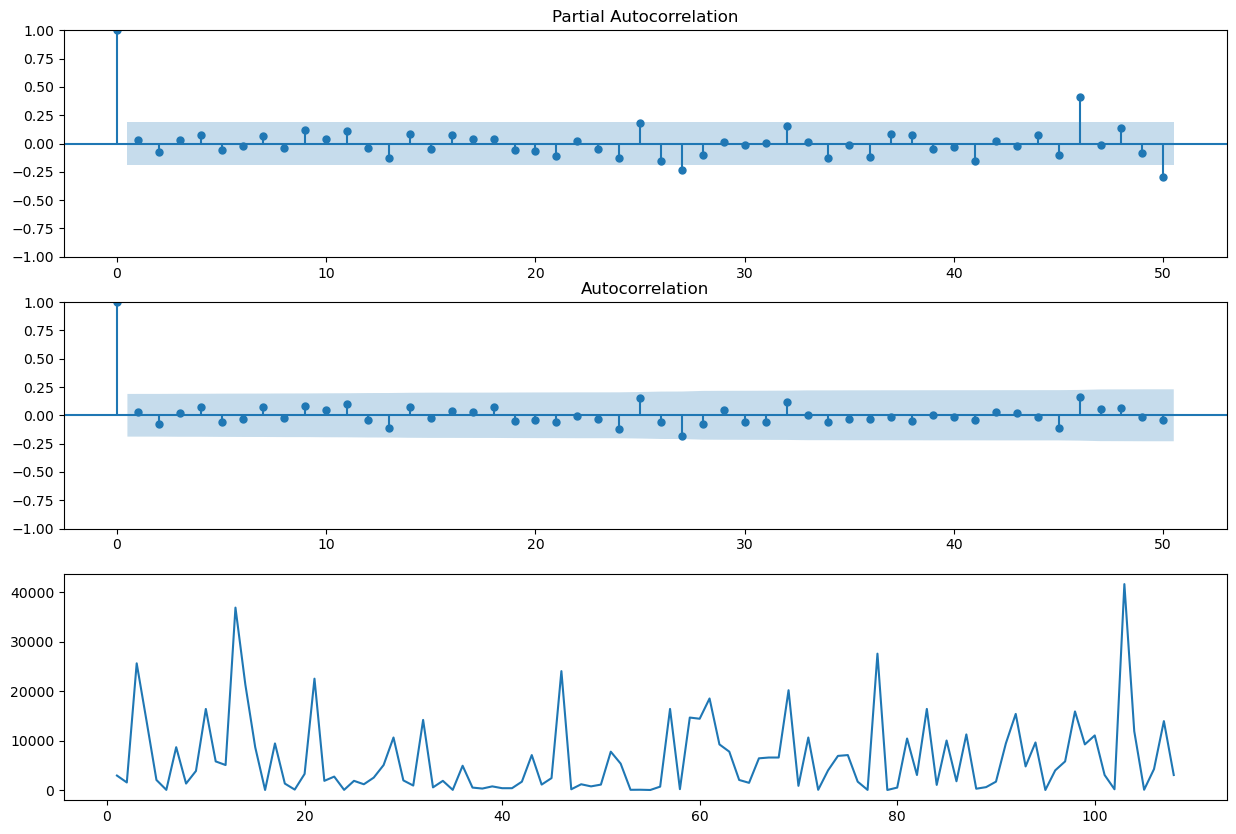

In [17]:
# we can check the square residuals and from the box test we see that the squares are uncorrelated
# therefore we cannot improve the linear model with a non linear model from the variance 

fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(r**2, lags = nlags, method="ld", ax=ax[0])
plot_acf(r**2, lags = nlags, ax=ax[1])
ax[2] = plt.plot(r**2)
plt.show()

In [21]:
box_test = sm.stats.acorr_ljungbox(r**2, lags=[20])
print("Box test for r^2")
print(box_test)

Box test for r^2
     lb_stat  lb_pvalue
20  8.985641   0.983073


In [11]:
# we get that the data is normal distributed (p value > 0.05, no reject H0 --> data normal)
# as we have WN, and GWN, the data is SWN and the data is independent. Therefore we can already say that we cannot predict anything better
# with the variance

from scipy.stats import shapiro

print("Shapiro test:", shapiro(r)[0])
print("Shapiro p-value: ", shapiro(r)[1])

Shapiro test: 0.9876300792573609
Shapiro p-value:  0.42447537816849523


In [23]:
# we need to understand our data before starting to apply the model
# from the correlation matrix we can see that the IBEX is highly correlated with the 3 independent random variables

# Correlation matrix

pd.DataFrame({"IBEX":np.corrcoef([y, x1, x2, x3])[0],
             "Exchange Rate":np.corrcoef([y, x1, x2, x3])[1],
             "Short term rate":np.corrcoef([y, x1, x2, x3])[2],
             "Long term rate":np.corrcoef([y, x1, x2, x3])[3]},
            index = ["IBEX", "Exchange Rate","Short term rate",
                    "Long term rate"])

,IBEX,Exchange Rate,Short term rate,Long term rate
IBEX,1.000000,0.888865,-0.931820,-0.944159
Exchange Rate,0.888865,1.000000,-0.842729,-0.867561
Short term rate,-0.931820,-0.842729,1.000000,0.866474
Long term rate,-0.944159,-0.867561,0.866474,1.000000


In [25]:
# Regression of y as a function of x1, x2 and x3
# first we need to find the best regression model for IBEX as a function of the 3 random related variables

x = pd.DataFrame({"Exchange Rate":x1, "Short term rate":x2, "Long term rate":x3})
x = sm.add_constant(pd.DataFrame(x))

reg1 = sm.OLS(y, x).fit() # the name of this model is reg1
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   IBEX   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     626.1
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           8.03e-67
Time:                        15:41:48   Log-Likelihood:                -682.62
No. Observations:                 109   AIC:                             1373.
Df Residuals:                     105   BIC:                             1384.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5231.6769    376.906     13.881      0.000    4484.341    5979.013
Exchange Rate     783.3436    288.440      2.716      0.008     211.421    1355.266
Short term rate   -88.7046     10.505     -8.444      0.000    -109.535     -67.874
Long term rate   -172.1635     18.923     -9.098      0.000    -209.685    -134.642
==============================================================================
Omnibus:                        2.633   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                2.251
Skew:                          -0.238   Prob(JB):                        0.324
Kurtosis:                       2.481   Cond. No.                         597.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

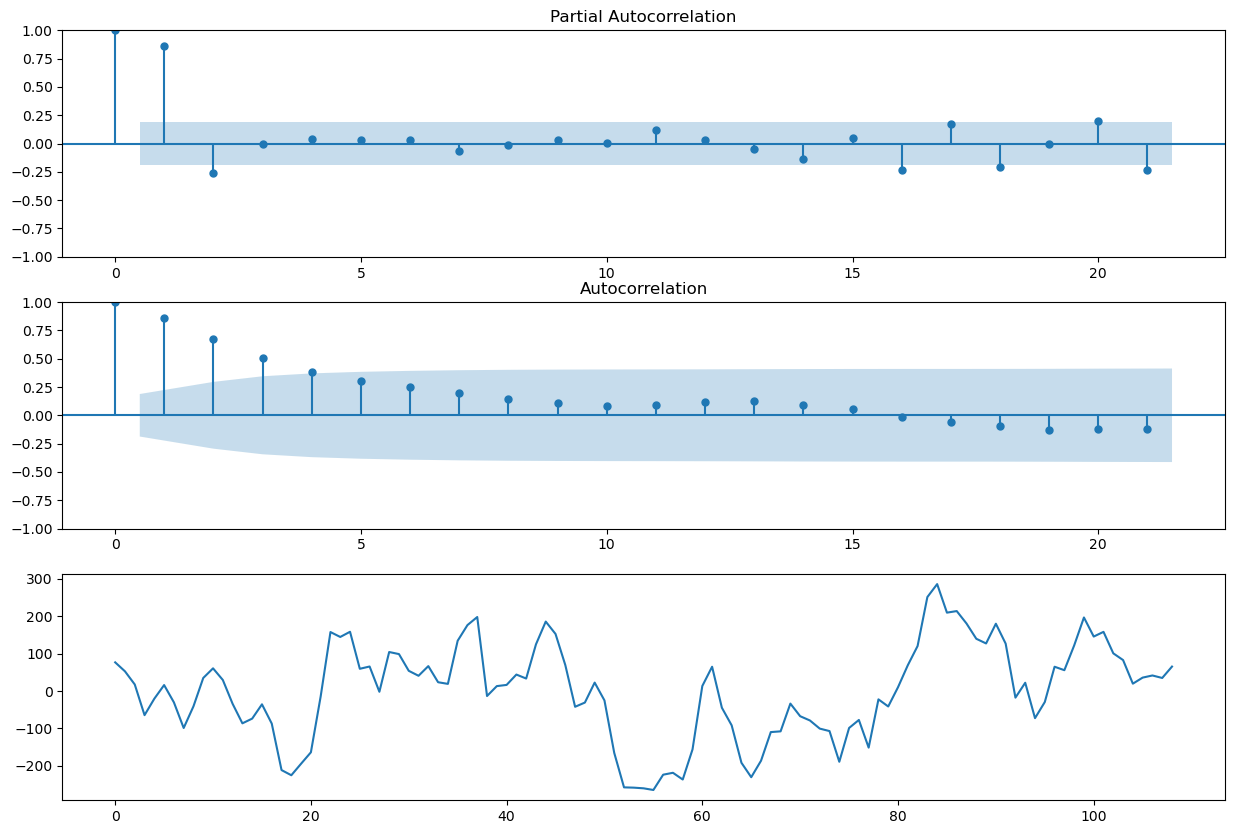

In [27]:
# after finding the regression model we need to check if the errors are or not stationary

resi = reg1.resid

fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(resi, method="ld", ax=ax[0])
plot_acf(resi, ax=ax[1])
ax[2] = plt.plot(resi)
plt.show()


# from the ACF we see that some bars are out of bound but they decay for 0 is "quite" fast, therefore our data is stationary but with doubts
# to see this better we can also check the plot of the residuals and the ADF test or other tests

In [29]:
# we can calculate the number of differences using the ADF test and other tests (e.g kpss)
# the problem is that the ADF test tells us to use 1 difference and the other no one
# therefore we would need to test both and then see which one is better forecasting

print('Regular difference test adf',ndiffs(resi, alpha = 0.05, test = 'adf'))
print('Regular difference test kpss',ndiffs(resi, alpha = 0.05, test = 'kpss'))

print("Two different test provide different answers. If we follow our intuition, the decay to zero in the acf is pretty fast, and we can assume that is stationary")
print("Of course you can try both models. You have the code for transforming the variables below")

Regular difference test adf 1
Regular difference test kpss 0
Two different test provide different answers. If we follow our intuition, the decay to zero in the acf is pretty fast, and we can assume that is stationary
Of course you can try both models. You have the code for transforming the variables below


In [31]:
# If we assume that the residuals are stationary
# we need to check if the residuals are or not WN, from the previous box test we can already see that they are not WN (lags out of bound)
# we see that the PACF is easier, we would need a AR(2), p=2, d=0

fit = sm.tsa.arima.ARIMA(resi, order = (2,0,0)).fit(method = 'innovations_mle')
# Prácticamente los mismos parámetros que en R
fit.summary()

# we see that all the coefficients are significant (except the constant)
# the constant is 0 (because it is not significant, and in the confidence intevral 0 is in the middle, this we already knew)
# the ecuation would be et=1.06et-1-0.24et-2+at

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  109
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -606.676
Date:                Sat, 18 Jan 2025   AIC                           1221.353
Time:                        15:50:02   BIC                           1232.118
Sample:                             0   HQIC                          1225.718
                                - 109                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6215     33.515      0.138      0.890     -61.067      70.310
ar.L1          1.0665      0.094     11.335      0.000       0.882       1.251
ar.L2         -0.2448      0.093     -2.623      0.009      -0.428      -0.062
sigma2      3946.2290    596.573      6.615      0.000    2776.967    5115.491
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.95   Prob(JB):                         0.92
Heteroskedasticity (H):               1.12   Skew:                            -0.06
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

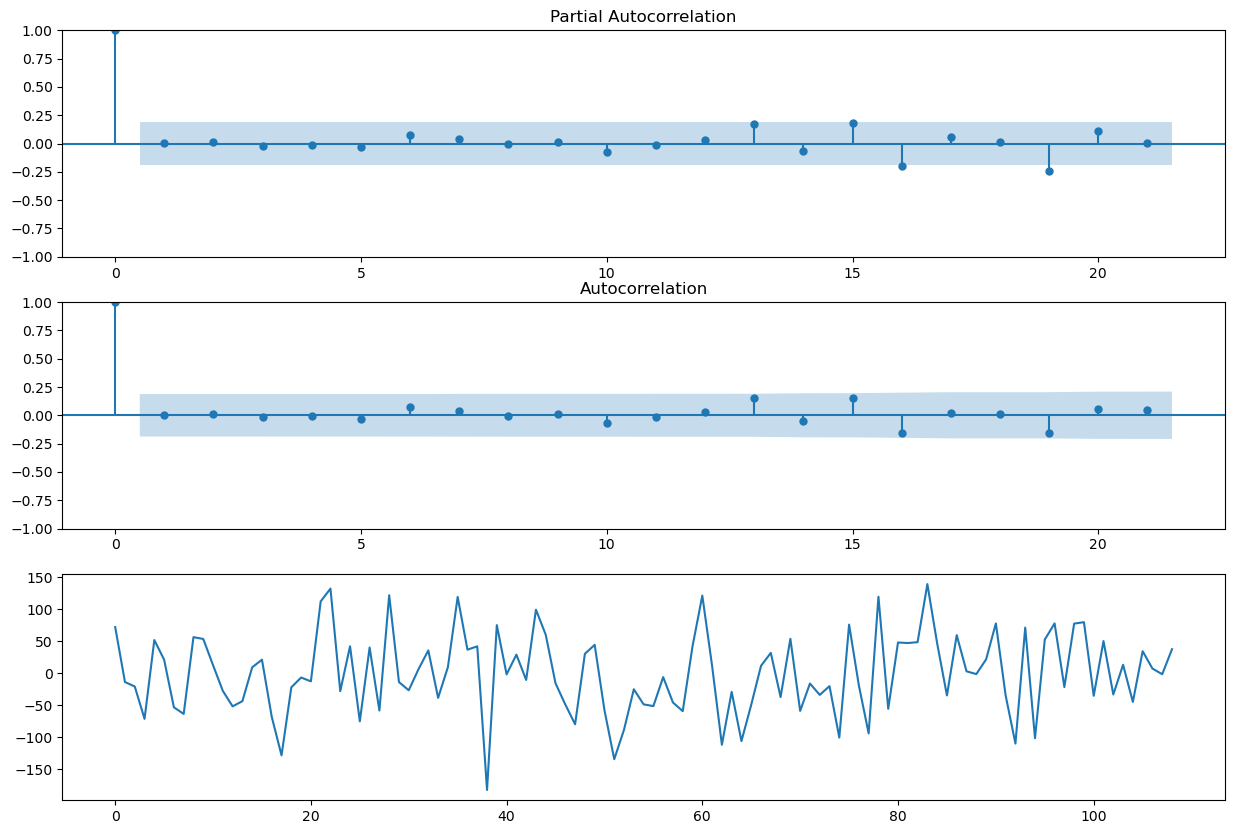

In [33]:
fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(fit.resid, method="ld", ax=ax[0])
plot_acf(fit.resid, ax=ax[1])
ax[2] = plt.plot(fit.resid)
plt.show()

# we see that now our residuals are white noise, and uncorrelated

In [18]:
box_test = sm.stats.acorr_ljungbox(fit.resid, lags=[5])
print(box_test)

    lb_stat  lb_pvalue
5  0.182631    0.99929


In [19]:
del(x['const'])

In [20]:
# Here we estimate the joint model, estimating together the regression model and the time series model for the residuals
# we use and endogenous variable (IBEX) and the x (which we have defined as the other 3 variables)
# the order for the model of the residuals is an AR(2) which we also include in this model
# to identify the models we need to do it step by step like before but once we already know the paramters we need to estimate everything together

fit_total = sm.tsa.arima.ARIMA(endog = y, exog = x, order = (2,0,0)).fit(method = 'innovations_mle')
fit_total.summary()

# Note: check if all the parameters are different from zero. If not, simplify the model removing what is not significant
# we see that the short term is not significant (this is because of multicollinearity), therfore we need to remove the short term variable
# also the arL2 is not significant so we also need to remove it

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   IBEX   No. Observations:                  109
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -595.667
Date:                Fri, 17 Jan 2025   AIC                           1205.334
Time:                        19:58:12   BIC                           1224.174
Sample:                             0   HQIC                          1212.974
                                - 109                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4493.1664    459.006      9.789      0.000    3593.532    5392.801
Exchange Rate     957.3415    366.842      2.610      0.009     238.344    1676.339
Short term rate   -10.7126     18.913     -0.566      0.571     -47.782      26.357
Long term rate   -192.6208     30.578     -6.299      0.000    -252.553    -132.688
ar.L1               1.0795      0.111      9.694      0.000       0.861       1.298
ar.L2              -0.1240      0.112     -1.106      0.269      -0.344       0.096
sigma2           3190.8831    501.853      6.358      0.000    2207.269    4174.497
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.18
Prob(Q):                              0.84   Prob(JB):                         0.34
Heteroskedasticity (H):               1.62   Skew:                             0.35
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

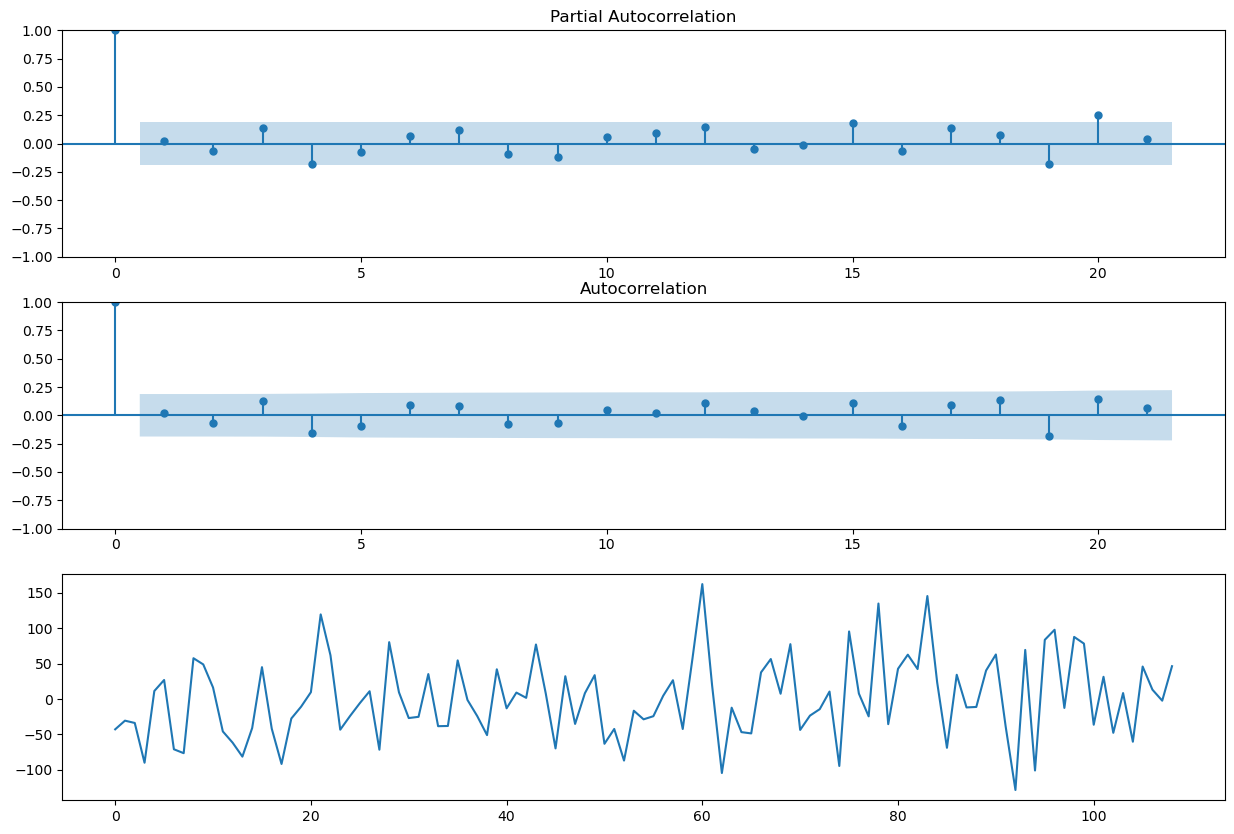

In [21]:
fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(fit_total.resid, method="ld", ax=ax[0])
plot_acf(fit_total.resid, ax=ax[1])
ax[2] = plt.plot(fit_total.resid)
plt.show()

In [22]:
box_test = sm.stats.acorr_ljungbox(fit_total.resid, lags=[30])
print(box_test)

      lb_stat  lb_pvalue
30  29.684932   0.481872


In [35]:
# What we do now is removing what is not significant and follow all the process again

xx = pd.DataFrame({"Exchange Rate":x1, "Long term rate":x3})

xx = sm.add_constant(xx)

reg2 = sm.OLS(y, xx).fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   IBEX   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     543.2
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           1.95e-56
Time:                        15:59:21   Log-Likelihood:                -710.86
No. Observations:                 109   AIC:                             1428.
Df Residuals:                     106   BIC:                             1436.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4435.4595    470.616      9.425      0.000    3502.418    5368.501
Exchange Rate   1676.1116    346.091      4.843      0.000     989.953    2362.271
Long term rate  -252.9438     21.056    -12.013      0.000    -294.689    -211.199
==============================================================================
Omnibus:                        3.392   Durbin-Watson:                   0.137
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                2.837
Skew:                           0.286   Prob(JB):                        0.242
Kurtosis:                       2.454   Cond. No.                         395.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

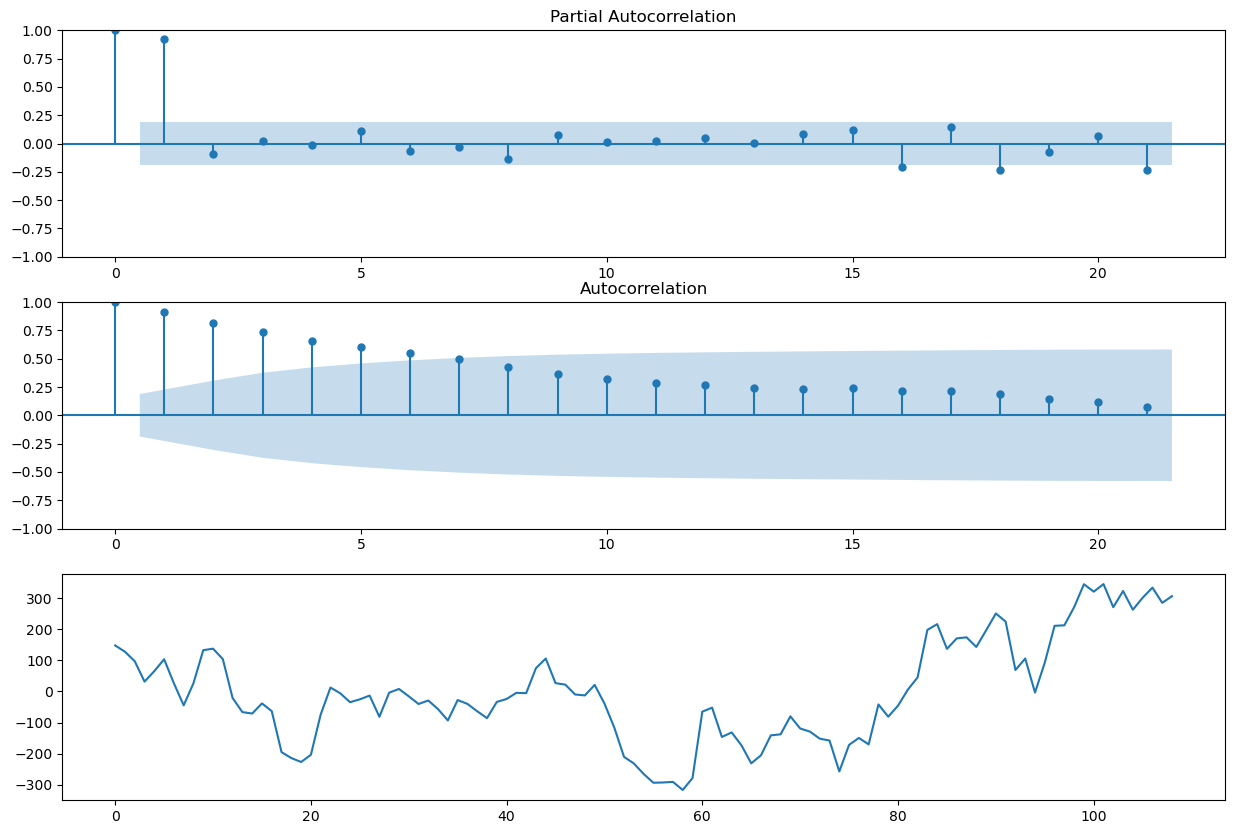

In [37]:
# we see that the 

fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(reg2.resid, method="ld", ax=ax[0])
plot_acf(reg2.resid, ax=ax[1])
ax[2] = plt.plot(reg2.resid)
plt.show()

In [39]:
fit = sm.tsa.arima.ARIMA(reg2.resid, order = (1,0,0)).fit(method = 'innovations_mle')
# Prácticamente los mismos parámetros que en R
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  109
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -602.298
Date:                Sat, 18 Jan 2025   AIC                           1210.596
Time:                        15:59:59   BIC                           1218.670
Sample:                             0   HQIC                          1213.870
                                - 109                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.1716     98.339      0.510      0.610    -142.570     242.913
ar.L1          0.9390      0.038     24.923      0.000       0.865       1.013
sigma2      3618.7497    484.211      7.473      0.000    2669.713    4567.787
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):                 2.57
Prob(Q):                              0.29   Prob(JB):                         0.28
Heteroskedasticity (H):               1.44   Skew:                             0.29
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
del(xx['const'])

In [43]:
fit_total2 = sm.tsa.arima.ARIMA(endog = y, exog = xx, order = (1,0,0)).fit(method = 'innovations_mle')
fit_total2.summary()
# Now all is significant

# in this case the new model is 
# IBEX = 4570 +881ExRt - 204 LTt + et
# et= 0.96et-1 + at

# now we need to check if the residuals now are white noise

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   IBEX   No. Observations:                  109
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -596.465
Date:                Sat, 18 Jan 2025   AIC                           1202.931
Time:                        16:00:04   BIC                           1216.387
Sample:                             0   HQIC                          1208.388
                                - 109                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4570.9047    451.330     10.128      0.000    3686.314    5455.495
Exchange Rate    881.1288    358.421      2.458      0.014     178.637    1583.620
Long term rate  -204.1997     25.389     -8.043      0.000    -253.961    -154.438
ar.L1              0.9665      0.024     40.113      0.000       0.919       1.014
sigma2          3234.0963    484.831      6.671      0.000    2283.845    4184.348
===================================================================================
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.28   Prob(JB):                         0.41
Heteroskedasticity (H):               1.51   Skew:                             0.31
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

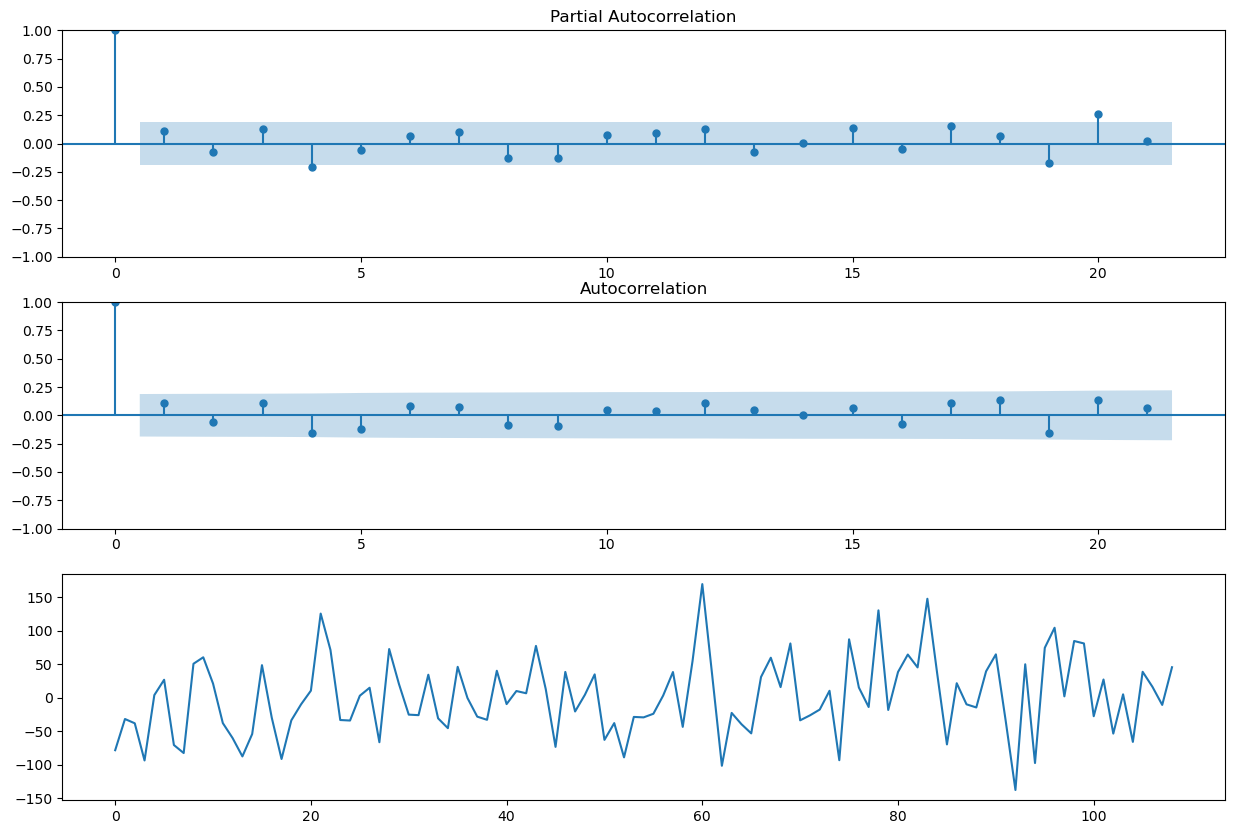

In [45]:
# Look at the residuals from the last reduced model to see if they are white noise
fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(fit_total2.resid, method="ld", ax=ax[0])
plot_acf(fit_total2.resid, ax=ax[1])
ax[2] = plt.plot(fit_total2.resid)
plt.show()

In [47]:
# residuals are already white noise
# residuals are uncorrelateed on the squares 
# and the residuals are gaussian (follow normallity)

# therefore we can say that we have the best linear model, we cannot improve it
# because of the squares we know that we dont need a linear model for the variance
# residuals are independent SWN
print("Box Test residuals")
box_test = sm.stats.acorr_ljungbox(fit_total2.resid, lags=[30])
print(box_test)

print("\nBox Test squared residusls")
box_test = sm.stats.acorr_ljungbox(fit_total2.resid **2, lags=[30])
print(box_test)

print("\nShapiro test", shapiro(fit_total2.resid)[0])
print("Shapiro test (p-value)", shapiro(fit_total2.resid)[1])

Box Test residuals
      lb_stat  lb_pvalue
30  28.366585   0.551017

Box Test squared residusls
      lb_stat  lb_pvalue
30  31.663469    0.38334


NameError: name 'shapiro' is not defined

In [30]:
# This is the final regression model with time series errors we have found
fit_total = sm.tsa.arima.ARIMA(endog = y, exog = xx, order = (1,0,0)).fit(method = 'innovations_mle')
fit_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   IBEX   No. Observations:                  109
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -596.465
Date:                Fri, 17 Jan 2025   AIC                           1202.931
Time:                        19:58:13   BIC                           1216.387
Sample:                             0   HQIC                          1208.388
                                - 109                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4570.9047    451.330     10.128      0.000    3686.314    5455.495
Exchange Rate    881.1288    358.421      2.458      0.014     178.637    1583.620
Long term rate  -204.1997     25.389     -8.043      0.000    -253.961    -154.438
ar.L1              0.9665      0.024     40.113      0.000       0.919       1.014
sigma2          3234.0963    484.831      6.671      0.000    2283.845    4184.348
===================================================================================
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.28   Prob(JB):                         0.41
Heteroskedasticity (H):               1.51   Skew:                             0.31
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Now we can predict with this model
# the numbers of the ex rate and long term rate we got them from the assignment, because it is what they are asking

pred_x = pd.DataFrame({"Exchange Rate":0.781, "Long term rate":10.76}, index = [0])

# we can calculate the prediction using the function forecast or the function predict, which they give the same value
# we can use the one we prefer
prediction = fit_total.forecast(exog=pred_x)
prediction2 = fit_total.predict(exog=pred_x, start = len(xx))
# two different ways to obtain the same point prediction
print('Prediction:', prediction)
print('Prediction 2:', prediction2)

Prediction: 109    3336.258929
dtype: float64
Prediction 2: 109    3336.258929
dtype: float64


In [49]:
# THIS PART OF THE CODE IS FOR THE CASES IN WHICH WE MUST TRANSFORM THE VARIABLES. 

# just in case we need to do the same taking differences first

dy = y.diff().dropna()
z1 = x1.diff().dropna()
z2 = x2.diff().dropna()
z3 = x3.diff().dropna()

In [51]:
pd.DataFrame({"IBEX_diff":np.corrcoef([dy, z1, z2, z3])[0],
             "Exchange Rate_diff":np.corrcoef([dy, z1, z2, z3])[1],
             "Short term rate_diff":np.corrcoef([dy, z1, z2, z3])[2],
             "Long term rate_diff":np.corrcoef([dy, z1, z2, z3])[3]},
            index = ["IBEX_diff", "Exchange Rate_diff","Short term rate_diff",
                    "Long term rate_diff"])

,IBEX_diff,Exchange Rate_diff,Short term rate_diff,Long term rate_diff
IBEX_diff,1.000000,0.248638,-0.327315,-0.683674
Exchange Rate_diff,0.248638,1.000000,-0.183727,-0.145037
Short term rate_diff,-0.327315,-0.183727,1.000000,0.446403
Long term rate_diff,-0.683674,-0.145037,0.446403,1.000000


In [53]:
z = pd.DataFrame({"Exchange Rate_diff":z1, "Short term rate_diff":z2, "Long term rate_diff":z3})
z = sm.add_constant(pd.DataFrame(z))

reg2 = sm.OLS(dy, z).fit()
reg2.summary()

# we see that the short term is already not significant, therefore we need to delete

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   IBEX   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     33.34
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           3.51e-15
Time:                        16:14:52   Log-Likelihood:                -590.33
No. Observations:                 108   AIC:                             1189.
Df Residuals:                     104   BIC:                             1199.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.5640      5.675      0.628      0.531      -7.689      14.817
Exchange Rate_diff     767.1516    360.198      2.130      0.036      52.865    1481.438
Short term rate_diff    -0.9214     14.469     -0.064      0.949     -29.613      27.770
Long term rate_diff   -200.5001     23.852     -8.406      0.000    -247.799    -153.201
==============================================================================
Omnibus:                        1.564   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.162
Skew:                           0.243   Prob(JB):                        0.559
Kurtosis:                       3.149   Cond. No.                         64.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

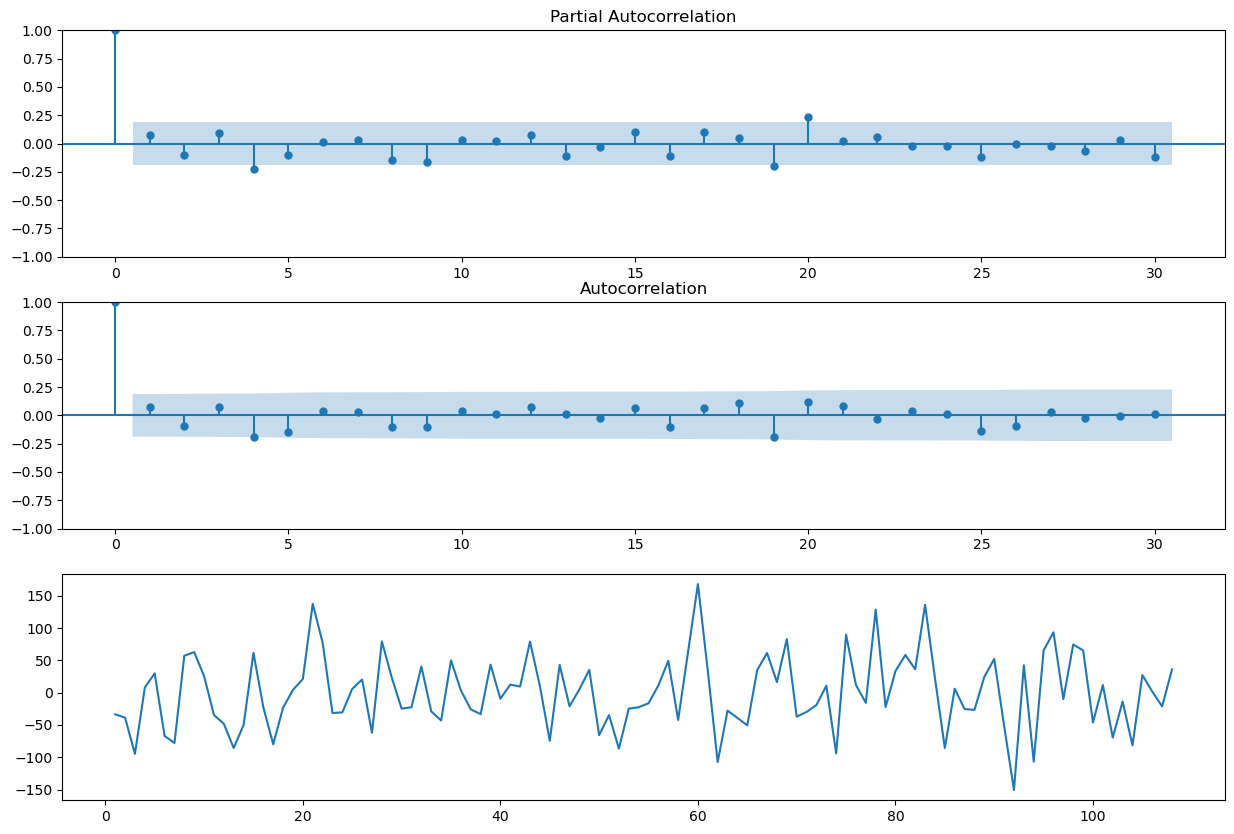

In [35]:
resi = reg2.resid

fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(resi, lags = 30, method="ld", ax=ax[0])
plot_acf(resi, lags = 30, ax=ax[1])
ax[2] = plt.plot(resi)
plt.show()

In [36]:
print('Regular differences:',ndiffs(resi, alpha = 0.05, test = 'adf'))


Regular differences: 0


In [ ]:
# we need to be careful at the end because the predictions will be the difference of IBEX, and we need to undo the transformation